# BIAS ANALYSIS

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import scipy.stats as stats
import statsmodels.api as sm

In [3]:
periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']

In [4]:
data = {}
for period in periods:
    data[period] = pd.read_csv(f"results/{period}_rf.csv")

NOTE: 

We trim the data at the 1% level each period before taking the average. divide annual by 4

Text(0.5, 1.0, 'Average bias of analysts earings expectations relative to machine learning forecasts')

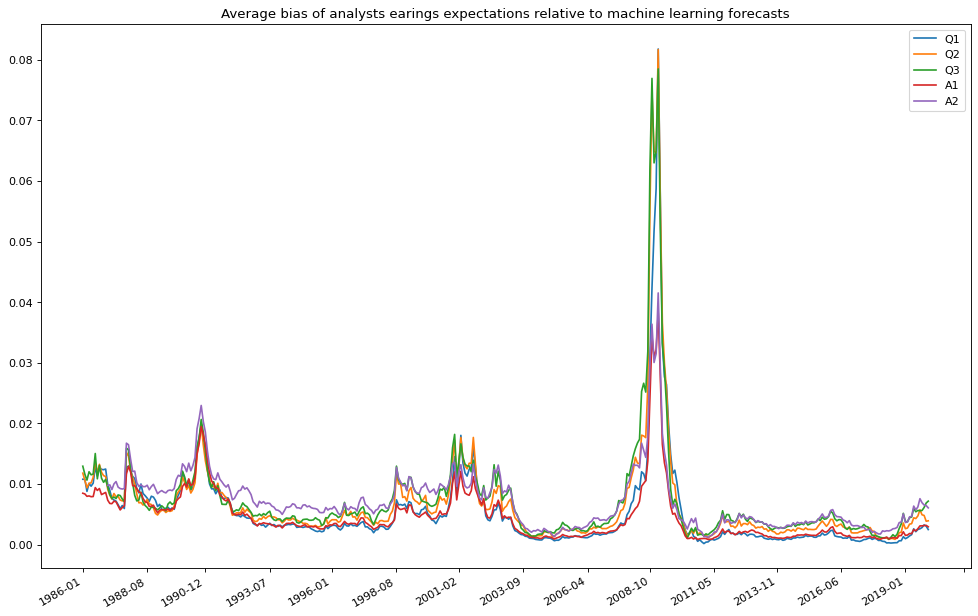

In [46]:
from scipy import stats
plt.figure(figsize=(15, 10), dpi=80)
for period, df in data.items():
    if period == 'A2' or period=='A1':
        df.biased_expectation = df.biased_expectation/4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()   
plt.title('Average bias of analysts earings expectations relative to machine learning forecasts') 

Text(0.5, 1.0, 'Average realized bias of analysts earings expectations')

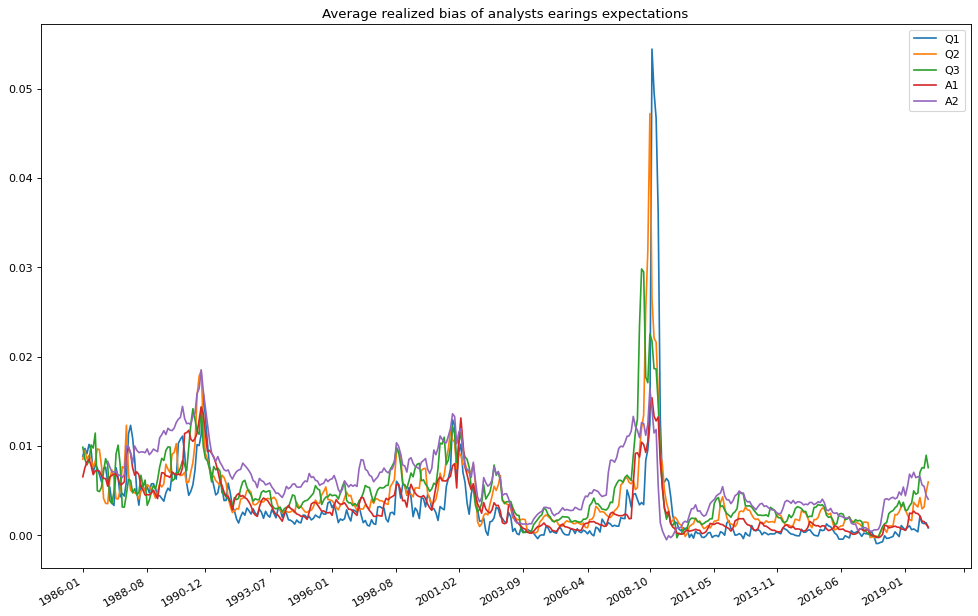

In [47]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in data.items():
    df['bias_analyst_actual'] = (df.adj_meanest - df.adj_actual) / df.price
    if period == 'A2' or period=='A1':
        df.bias_analyst_actual = df.bias_analyst_actual / 4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()  
plt.title('Average realized bias of analysts earings expectations') 


In [48]:
def compute_bias_results ( period):
    df = data[period]
    RF = df.predicted_adj_actual.mean()
    AF = df.adj_meanest.mean()
    AE = df.adj_actual.mean()
    RF_AE = (df.predicted_adj_actual - df.adj_actual).mean()
    AF_AE = (df.adj_meanest - df.adj_actual).mean()
    RF_AE2 = ((df.predicted_adj_actual - df.adj_actual)**2).mean()
    AF_AE2 = ((df.adj_meanest - df.adj_actual)**2).mean()
    bias = ((df.adj_meanest - df.predicted_adj_actual) / df.price).mean()

    return {'value': period,'RF': round(RF, 3), 'AF': round(AF, 3), 'AE':round(AE, 3),'(RF-AE)':round(RF_AE, 3), '(AF-AE)':round(AF_AE, 3),
    '(RF-AE)^2':round(RF_AE2, 3), '(AF-AE)^2': round(AF_AE2, 3), '(AF-RF)/P':round(bias, 3), 'N':len(df) }
    

In [49]:
# Create an empty dictionary to store DataFrames
results = []

for period in periods:
    results.append(compute_bias_results(period))

In [50]:
display(pd.DataFrame(results).set_index('value').rename_axis(None))

,RF,AF,AE,(RF-AE),(AF-AE),(RF-AE)^2,(AF-AE)^2,(AF-RF)/P,N
Q1,0.251,0.275,0.255,-0.004,0.020,0.123,0.210,0.005,927509
Q2,0.266,0.314,0.269,-0.003,0.046,0.144,0.149,0.007,843189
Q3,0.281,0.347,0.283,-0.002,0.064,0.172,0.205,0.007,774370
A1,0.926,1.053,0.933,-0.007,0.120,0.461,0.591,0.021,971732
A2,1.045,1.385,1.048,-0.003,0.337,1.058,1.798,0.030,813602


In [51]:
df = data['A1']
t, p = stats.ttest_1samp(df.predicted_adj_actual -  df.adj_actual, 0, alternative='two-sided')
print(f't-test is {t}')
print(f'p-value is {p}')

t-test is -9.555812022212555
p-value is 1.2288756423753302e-21


In [52]:
df = data['Q3']
df['RF_AE'] = (df.adj_meanest - df.predicted_adj_actual) 
model = sm.OLS( exog = np.ones(len(df)), endog = df.RF_AE).fit()
new = model.get_robustcov_results(cov_type='HAC',maxlags=3)
T_test = new.t_test([1]) 
print(T_test)



                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0662      0.000    187.307      0.000       0.066       0.067


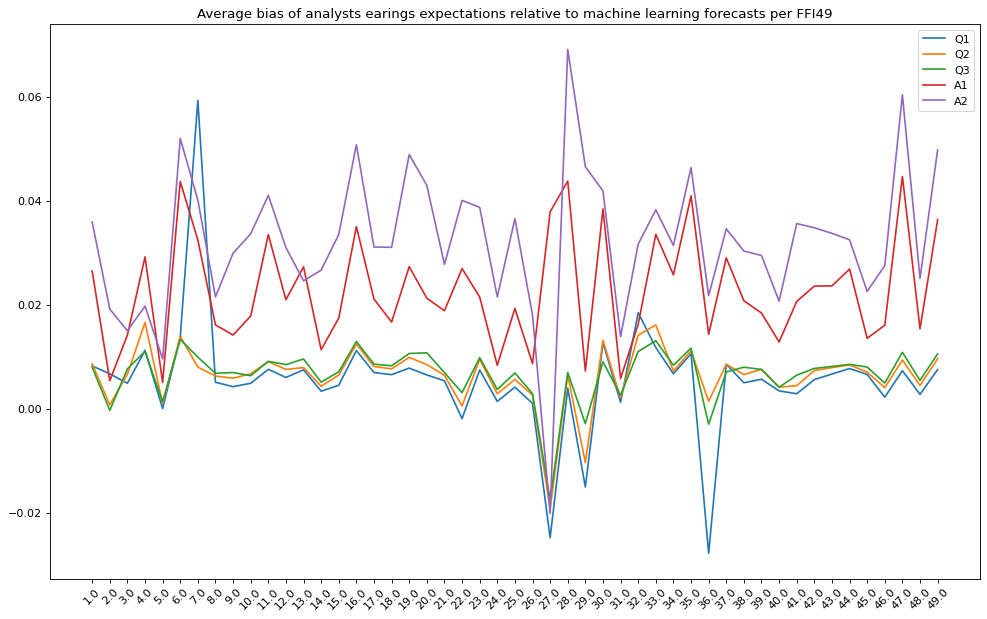

In [19]:
plt.figure(figsize=(15, 9), dpi=80)
for period in periods: 
    df = data[period].copy()
    df.sort_values('ffi49', inplace=True)
    #if period == 'A2' or period=='A1':
       # df.biased_expectation = df.biased_expectation / 4
    plt.plot(df.ffi49.unique().astype(str), df.groupby(['ffi49']).biased_expectation.apply(lambda x: x.mean()), label=period);  #stats.trim_mean(x, 0.01)
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per FFI49') 

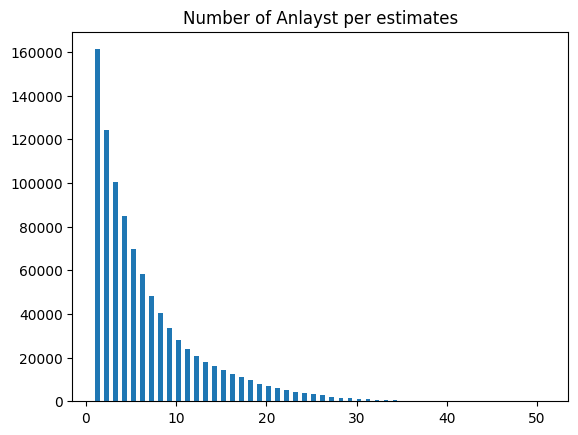

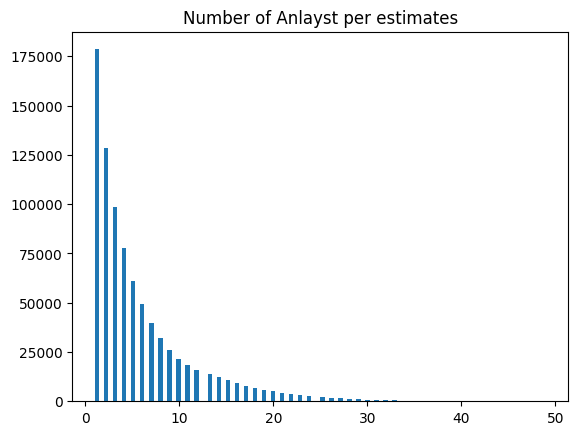

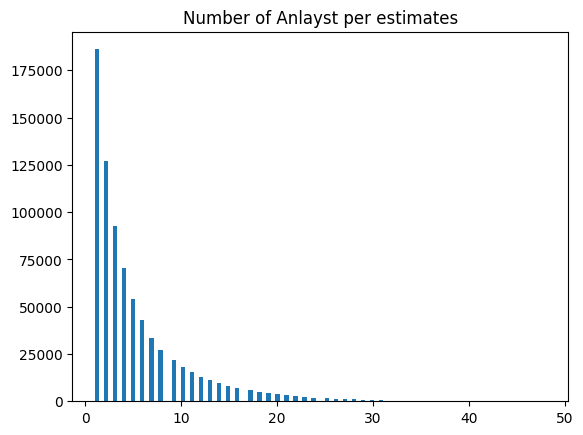

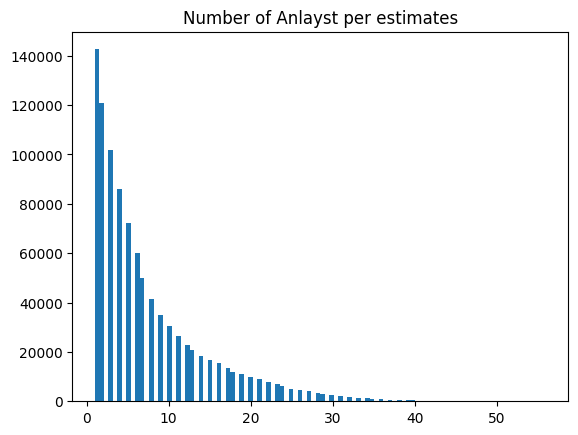

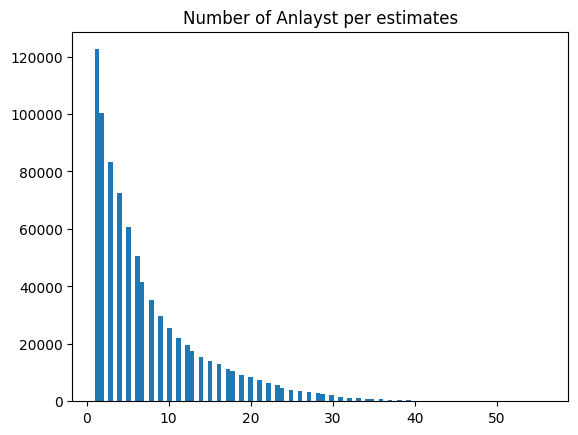

In [10]:
for period in periods: 
    plt.figure()
    df = data[period].copy()
    plt.hist(df.numest, bins=100)
    plt.title('Number of Analyst per estimates') 

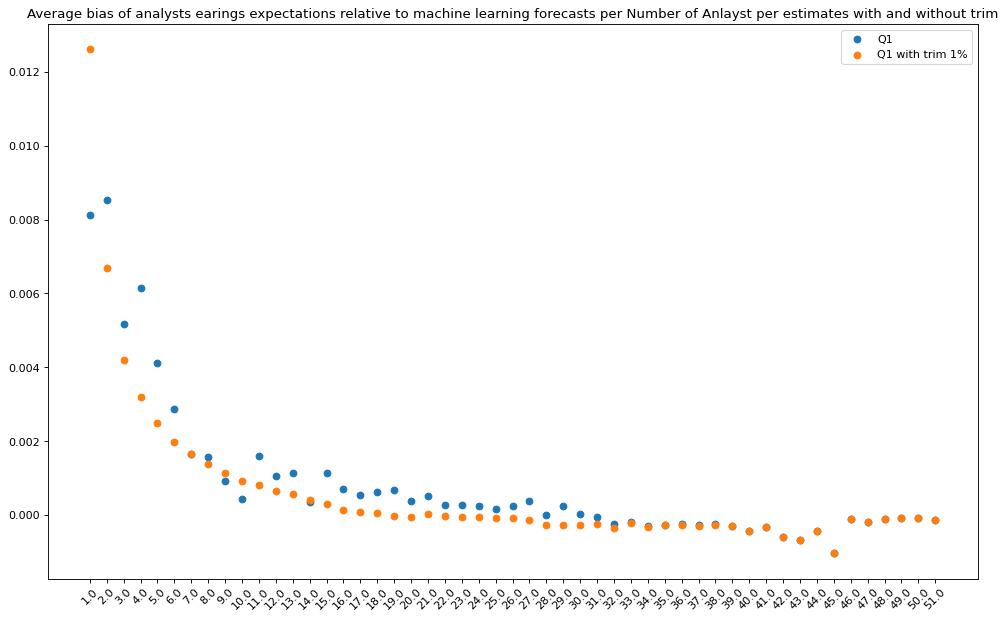

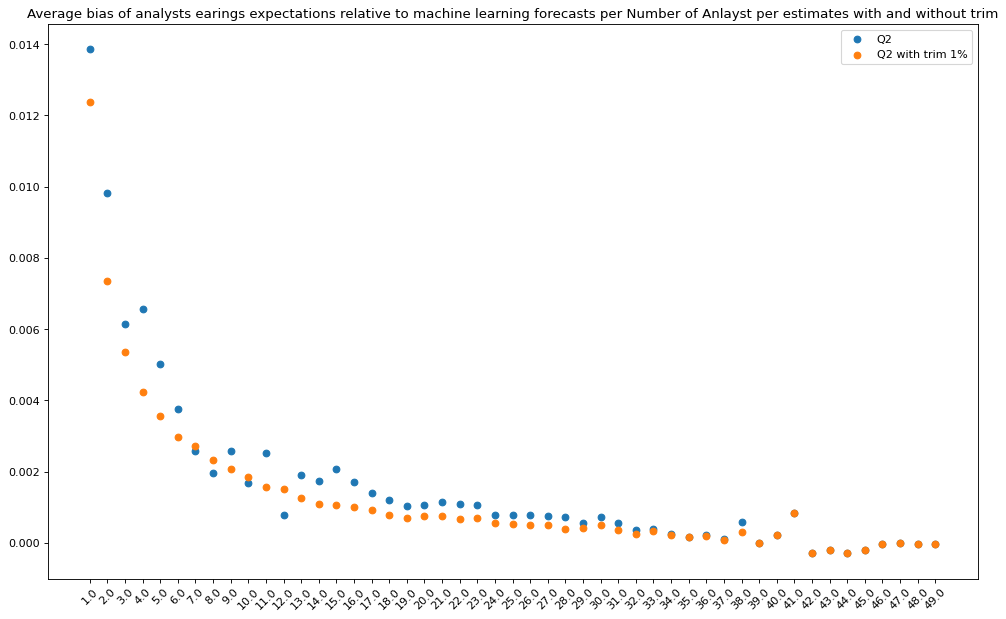

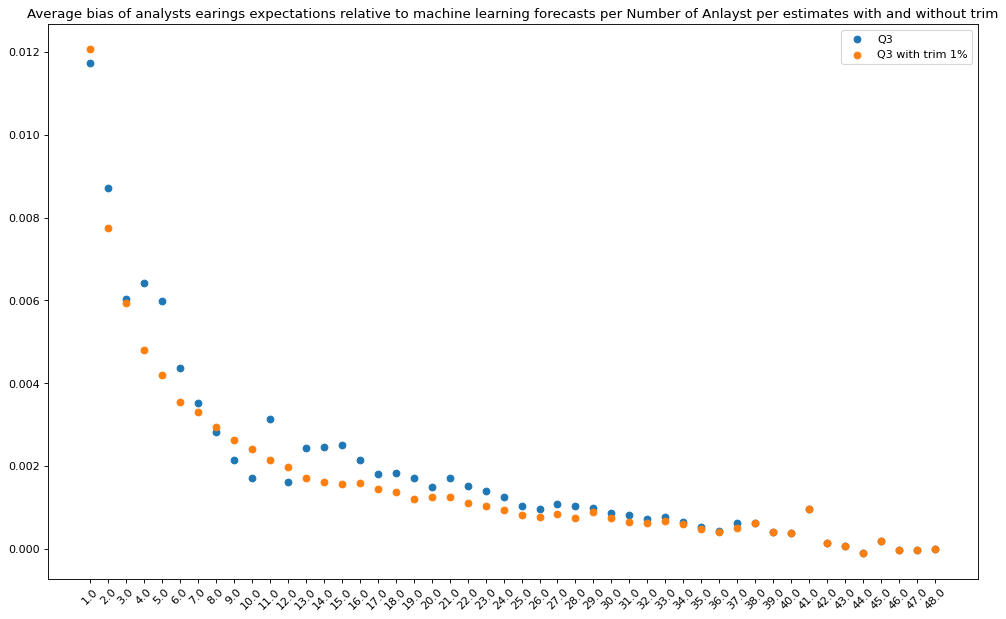

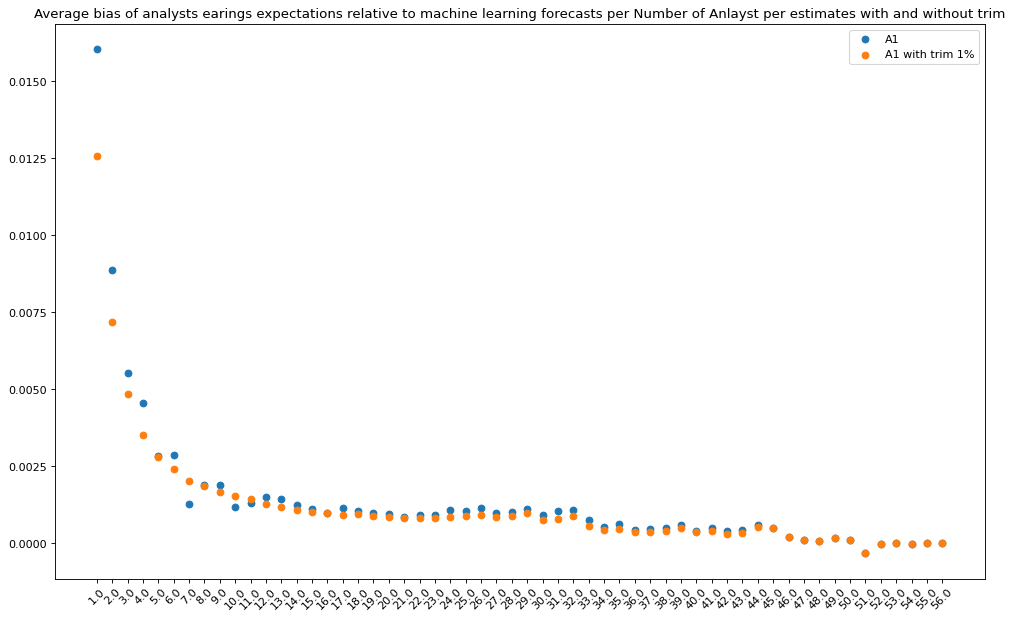

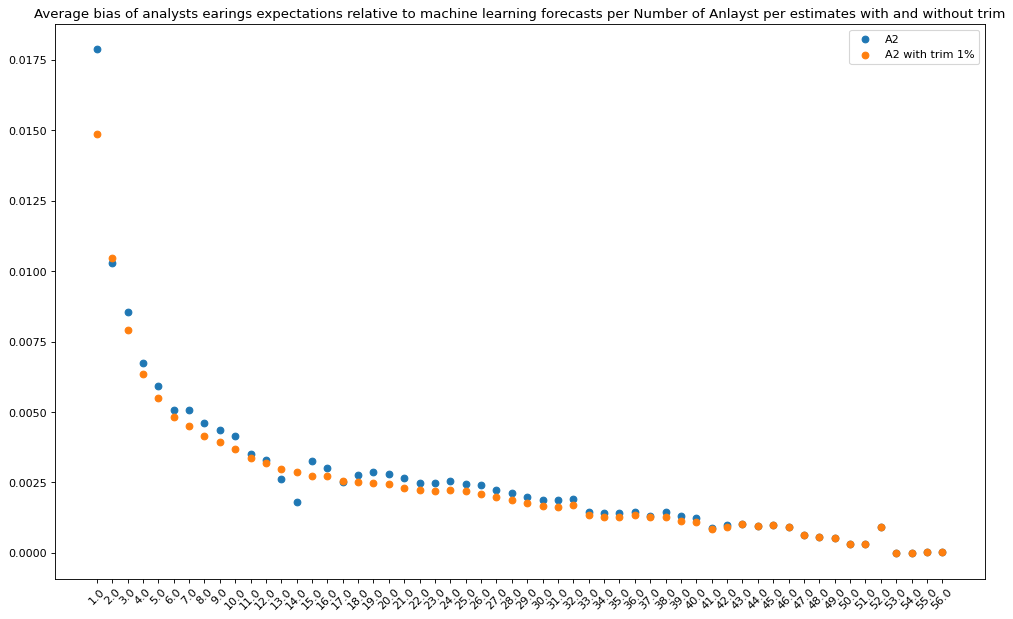

In [20]:
for period in periods: 
    plt.figure(figsize=(15, 9), dpi=80)
    df = data[period].copy()
    df.sort_values('numest', inplace=True)
    if period == 'A2' or period=='A1':
        df.biased_expectation = df.biased_expectation / 4
    plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).biased_expectation.apply(lambda x: x.mean()), label=f'{period}'); #stats.trim_mean(x, 0.01)
    plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).biased_expectation.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period} with trim 1%'); 
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per Number of Anlayst per estimates with and without trim') 